# Sistemas de recomendación

Para aplicar el algoritmo de recomendación de contenido usaremos el data set de Movie Lens obtenidos en [este enlace](http://files.grouplens.org/datasets/movielens/). Tomaremos aquel que cuenta con 100.000 filas para evitar sobrecargar el ordenador.

### Carga de datos de Movie Lens

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../datasets/movies/ml-100k/u.data", sep="\t",header=None)
df.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
df.shape

(100000, 4)

In [4]:
df.columns

Int64Index([0, 1, 2, 3], dtype='int64')

Los nombres de las columnas debemos establecerlos nosotros.

In [5]:
column_names = ['UserID','ItemID','Rating','TimeStamp']

In [6]:
df.columns = column_names

In [7]:
df.head()

,UserID,ItemID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
import matplotlib.pyplot as plt

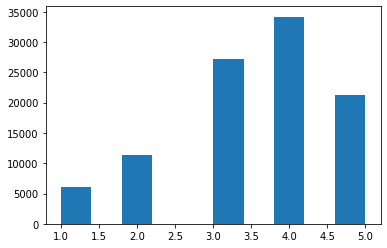

In [9]:
plt.hist(df.Rating)
plt.show()

In [10]:
df.groupby(["Rating"])["UserID"].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

Vemos que las puntuaciones tienden a concentrarse entre las 3 y las 5 estrellas.

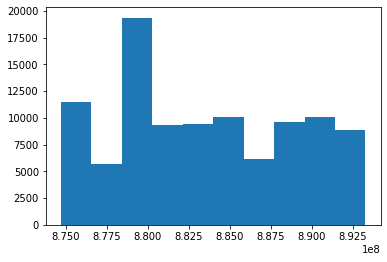

In [11]:
plt.hist(df.TimeStamp)
plt.show()

Vemos que la distribución a lo largo del tiempo es bastante uniforme.

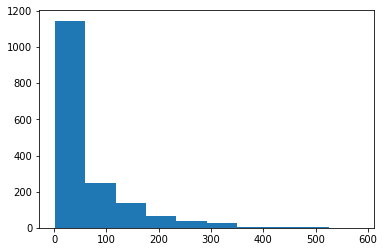

In [12]:
plt.hist(df.groupby(["ItemID"])["ItemID"].count())
plt.show()

Ahora hemos agrupado el número de visualizaciones por película, y vemos que algunas de ellas han sido más vistas que otras. De hecho el número de ítem (película) parece estar ordenado según el número de visualizaciones.

Esto se tendrá que tener en cuenta para evitar que nuestro algoritmo siempre recomiende las mismas películas dado este contexto, añadiendo películas de las que son menos vistas aleatoriamente.

## Representación en forma matricial

Para poder llevar a cabo un sistema de recomendaciones necesitamos disponer los datos de manera matricial basado en un sistema de valoraciones.

Esta matriz tendrá forma de array de números en el que cada fila se corresponderá con un usuario y cada columna con la valoración que cada usuario le haya dado a cada película.

In [13]:
n_users = df.UserID.unique().shape[0]
n_users

943

In [14]:
n_items = df.ItemID.unique().shape[0]
n_items

1682

Ahora creamos el array para guardar los datos en forma de matriz como se describió anteriormente.

In [15]:
ratings = np.zeros((n_users,n_items))

Ahora rellenamos la matriz con un bucle, teniendo en cuenta que los ID de usuario e ítem empiezan en 1.

In [16]:
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

In [17]:
type(ratings)

numpy.ndarray

In [18]:
ratings.shape

(943, 1682)

In [19]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

El resultado obtenido es lo que se conoce como una matriz `sparced`, es decir, una matriz en la que la mayor cantidad de valores son `cero`.

Podemos encontrar el coeficiente de esparceidad, es decir, la proporción de valores de la matriz que no son cero de la siguiente forma:

* `ratings.nonzero()` es un método que devuelve los valores distintos de 0 en el array, por filas y columnas
* Dividimos la cantidad de valores distintos de cero por el total de valroes en la matriz (filas·columnas)
* Multiplicamos por 100 para el porcentaje

In [20]:
sparcity = float(len(ratings.nonzero()[0]))
sparcity /= (ratings.shape[0]*ratings.shape[1])
sparcity *= 100
print("El coeficiente de esparceidad es del %4.2f%%"%sparcity)

El coeficiente de esparceidad es del 6.30%


## Crear conjuntos de entrenamiento y validación

A continuación usaremos `sklearn` para dividir nuestros datos

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
ratings_train, ratings_test = train_test_split(ratings, test_size=0.3,random_state=42)

In [23]:
ratings_train.shape

(660, 1682)

In [24]:
ratings_test.shape

(283, 1682)

Para el filtrado colaborativo basado en usuarios (en esto se basa el sistema de recomendación) lo que haremos será predecir qué usuario para un ítem dado se le va a ofrecer dicho ítem si la suma ponderada del resto de usuarios para dicho ítem es similar a la que ha ofrecido.

Es decir, tendré que buscar usuarios que sean similares y ponderar sus decisiones (las películas que ha visto y cuánto le han gustado) para recomendárselas a usuarios similares.

## Filtro colaborativo basado en usuarios

El procedimiento para crear un filtro basado en usuarios es el siguiente:

* Matriz de similaridad entre los usuarios (basado en la distancia del coseno)
* Predecir la valoración desconocida de un ítem *i* para un usuario activo *u* basándonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem
* Recomendaremos los nuevos ítems a los usuarios según lo establecido en los anteirores pasos

Al usar la distancia del coseno, cuanto más cercana a cero sea esta, más similares serán los usuarios; mientras que la similaridad es lo contrario, es decir, cuanto más alta sea la similaridad entre dos elementos más parecidos son.

Por tanto, la similaridad y la distancia emergen como conceptos antepuestos. Por lo tanto invertiremos los valores de la distancia para obtener la matriz de similaridad.

In [25]:
import sklearn

In [26]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [27]:
type(sim_matrix)

numpy.ndarray

In [28]:
sim_matrix.shape

(660, 660)

In [29]:
sim_matrix

array([[1.        , 0.17448349, 0.18009754, ..., 0.13331459, 0.17695593,
        0.21882481],
       [0.17448349, 1.        , 0.07993097, ..., 0.07175808, 0.09552622,
        0.05512655],
       [0.18009754, 0.07993097, 1.        , ..., 0.0191736 , 0.02233385,
        0.10310785],
       ...,
       [0.13331459, 0.07175808, 0.0191736 , ..., 1.        , 0.04853428,
        0.05142508],
       [0.17695593, 0.09552622, 0.02233385, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.21882481, 0.05512655, 0.10310785, ..., 0.05142508, 0.1198022 ,
        1.        ]])

Esta misma matriz la podríamos haber obtenido con el método `cosine_similarity` de `sklearn`, obteniendo el mismo resultado.

In [30]:
sim_matrix = sklearn.metrics.pairwise.cosine_similarity(ratings_train)

Como se estableció anteriormente, habrá que predecir las valoraciones de los ítems que el usuario no ha puntuado para establecer un orden de recomendación.

Lo haremos ponderando la matriz de distancias con las valoraciones de los usuarios que sí se han llevado a cabo y normalizando para que no aparezcan puntuaciones con valores que se salgan de las establecidas.

* `sim_matrix.dot(ratings_train)` llevará a cabo el producto matricial entre ambas matrices
* Lo dividiremos por la suma de los valores absolutos por columnas con `np.abs([np.abs(sim_matrix).sum(axis=1)])
* Lo pasamos a columna con `.T` para que se realice la operación correctamente

In [31]:
users_predictions = sim_matrix.dot(ratings_train)/np.array([np.abs(sim_matrix).sum(axis=1)]).T

Ahora crearemos una función para analizar el error cuadrático (`root mean squared error`) del modelo que hemos creado.

Para ello restaremos el valor de las predicciones a los valores originales que no fueran cero para ver que tanto se ajusta la predicción a la realidad.

In [39]:
def get_mse(preds, actuals):
    
    # cargamos la librería necesaria
    from sklearn.metrics import mean_squared_error
    
    # transponemos la matriz de actuales para que tengan la misma forma que las prdicciones
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    
    # nos quedamos con los que no fueran cero y los pasamos a vector con flatten()
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    
    return mean_squared_error(preds, actuals)

In [40]:
users_predictions.shape[0] != ratings_train.shape[0]

False

In [41]:
users_predictions.shape

(660, 1682)

In [42]:
ratings_train.shape

(660, 1682)

In [43]:
ratings_test.shape

(283, 1682)

In [44]:
e_train = get_mse(users_predictions, ratings_train)
print("Error cuadrático medio para el conjunto de entrenamiento: ", e_train)

Error cuadrático medio para el conjunto de entrenamiento:  7.878218313143215


In [45]:
e_test = get_mse(users_predictions, ratings_test)
print("Error cuadrático medio para el conjunto de validación: ", e_test)

Error cuadrático medio para el conjunto de validación:  8.745164067978985


El error crece un poco con el conjunto de validación.

Además, el error que obtenemos es alto. Que el error sea de 7 u 8 puntos quiere decir que una película que el algoritmo haya valorado con `0*`, el usuario la pueda valorar con `5*` y viceversa.

La razón por la que aparece tanta variabilidad en los datos es porque hemos decidido tener en cuenta aboslutamente todas las valoraciones de los usuarios para que el algoritmo tome la decisión final de la predicción.

## Filtro colaborativo basado en los KNN (usuarios)

El siguiente paso será refinar el algoritmo usando la técnica de los K Nearest Neighbors, de manera que para obtener las predicciones, en lugar de tener en cuenta a todos los usuarios, solamente tomamos los k más similares. 

Evaluaremos si se ajusta mas este modelo comparando los errores cuadráticos medios obtenidos.

In [46]:
from sklearn.neighbors import NearestNeighbors

Lo primero será definir el top `k` de usuarios similares que van a decidir nuestro modelo de recomendación. Esta es una decisión que tendremos que tomar nosotros mismos, por lo que podremos ir jugando con el valor hasta ajustar lo mejor posible nuestras predicciones.

En primer lugar, ajustaremos el modelo con el conjunto de entrenamiento. El modelo nos devolverá los `k` vecinos más cercanos a cada usuario y las distancias entre ellos.

In [47]:
k = 5

In [48]:
neighbors = NearestNeighbors(k, 'cosine')
neighbors.fit(ratings_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2,
         radius='cosine')

In [49]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)

In [50]:
top_k_distances.shape

(660, 5)

In [51]:
top_k_users.shape

(660, 5)

Le podemos pedir las distancias respecto al primer usuario de sus `k` vecinos más cercanos.

Recordemos que, al ser distancias, cuanto más cercanos sean los usuarios, menor será el valor de la distancia.

In [52]:
top_k_distances[0]

array([ 0.        , 41.71330723, 43.3474336 , 45.04442252, 45.04442252])

Así como los ID de los `k` vecinos más cercanos.

In [53]:
top_k_users[0]

array([  0, 211,  16, 583, 428])

Lo siguiente será elegir de todos esos usuarios y debido a la cercanía solo se tomaran dichas valoraciones ponderadas para establecer las recomendaciones.

In [54]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]): # para cada usuario del conjunto de entrenamiento
    
    # calculamos las predicciones normalizadas
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i])/np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [55]:
users_predicts_k.shape

(660, 1682)

In [56]:
users_predicts_k

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.74469557, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.9753676 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [57]:
get_mse(users_predicts_k, ratings_train)

8.180803170774984

In [58]:
get_mse(users_predicts_k, ratings_test)

11.338914012692959

## Filtro colaborativo basado en Ítems

El filtro colaborativo basado en Ítems es muy similar al anterior, exceptuando el procedimiento para obtener la matriz de similaridades: en este caso se buscará entre películas.

In [59]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [60]:
neighbors = NearestNeighbors(n_movies, 'cosine')

Esta vez transponemos la matriz del conjunto de entrenamiento para que las películas queden en filas.

In [61]:
neighbors.fit(ratings_train.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=1682, p=2,
         radius='cosine')

In [62]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

Con lo que obtenemos una matriz de distancias entre películas, y los `k` ítems más cercanos a cada una de ellas.

In [63]:
top_k_distances.shape

(1682, 1682)

In [64]:
top_k_items[0]

array([  0, 120, 404, ..., 285, 312, 301])

Ahora predecimos la valoración de la película con el producto matricial normalizado, como se hizo anteriormente.

In [65]:
item_preds = ratings_train.dot(top_k_distances)/np.array([np.abs(top_k_distances).sum(axis=1)])

In [66]:
item_preds

array([[0.        , 0.31842643, 0.37009323, ..., 1.44850442, 1.4566397 ,
        1.54530823],
       [0.        , 0.0545379 , 0.06227954, ..., 0.20078701, 0.20112087,
        0.21332472],
       [0.        , 0.03522479, 0.04073126, ..., 0.18456903, 0.18654661,
        0.20076303],
       ...,
       [0.        , 0.08968346, 0.10313623, ..., 0.42050197, 0.4196067 ,
        0.45863507],
       [0.        , 0.25835756, 0.29918119, ..., 1.31043371, 1.32278067,
        1.41390683],
       [0.        , 0.07174777, 0.08538024, ..., 0.25535196, 0.25259645,
        0.26199652]])

Finalmente pasamos a comparar los errores obtenidos con este modelo para comprobar cuál de los dos filtros que hemos creado ajusta mejor las predicciones.

In [67]:
get_mse(item_preds, ratings_train)

11.172565375125632

In [68]:
get_mse(item_preds, ratings_test)

11.876775601508902

## Filtrado colaborativo basado en KNN (ítems)

Al igual que hicimos antes, procuraremos afinar un poco más el algoritmo de recomendación diseñado en base a las distancias entre películas usando un `KNN`.

In [69]:
k = 30
neighbors = NearestNeighbors(k,'cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [70]:
top_k_distances.shape

(1682, 30)

Ahora solo buscamos el top `k` de películas más parecidas. Si quiero ver las 30 películas más parecidas a la película 0 (Toy Story) lo hago de la siguiente manera.

In [71]:
top_k_items[0]

array([  0, 120, 404, 116, 221, 150, 117, 180,   6, 741,  27,  94, 256,
       236, 124,  81,  24, 587, 227, 110, 234,  78, 203, 545,  70,  14,
        68, 596,  49, 143])

Y las distancias a ese mismo ítem de la siguiente forma.

In [72]:
top_k_distances[0]

array([ 0.        , 53.12249994, 54.38749856, 55.50675635, 56.49778757,
       56.9473441 , 57.21013896, 57.81003373, 58.10335619, 58.16356248,
       58.19793811, 58.37807808, 58.70264049, 58.83876273, 58.97457079,
       59.52310476, 59.61543424, 59.84981203, 59.89156869, 59.94163828,
       60.15812497, 60.35726965, 60.37383539, 60.63002556, 60.86049622,
       61.11464636, 61.31883887, 61.37589103, 61.57109712, 61.80614856])

Ahora pasamos a la predicción basada en este top `k`.

In [73]:
items_preds_k = np.zeros(ratings_train.T.shape)

for i in range(ratings_train.T.shape[0]):
    
    # hago loop sobre las películas y normalizo
    items_preds_k[i,:] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([np.abs(top_k_distances[i]).sum(axis=0)]).T
    #users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i])/np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

/Users/carlosdavila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [74]:
get_mse(preds, ratings_train)

8.732017359673444

In [78]:
import math
get_mse(preds, ratings_test)

TypeError: only size-1 arrays can be converted to Python scalars

### Conclusiones

En los resultados obtenidos vemos que el `MSE` ha sido elevado, por lo general. Esto puede ser debido a que la cantidad de datos disponible no es suficiente como para afinar el filtro de recomendación colaborativo.

Este sistema está poco explicado.